In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from PIL import Image

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn import neighbors
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm

from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import cv2
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

# Algorithms

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score, f1_score, plot_confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def create_vectorizer(train_data, *kwargs, max_features=1):
    vectorizer = CountVectorizer(max_features=max_features)
    res        = [vectorizer]
    res.append(vectorizer.fit_transform(train_data).toarray())
    for arg in kwargs:
        res.append(vectorizer.transform(arg).toarray())
    return res

scaler = None
def create_scaling(X):
    global scaler
    scaler = StandardScaler().fit(X)

def remove_outlyers(data, label, threshold=100):
    mask = (data>threshold).sum(axis=1)==0
    print("removing {} rows\n".format(np.sum(~mask)))
    return [data[mask], label.drop(label.index[~mask])]

def create_knn(train_data, target, **kwargs):
    clf = KNeighborsClassifier(**kwargs)
    clf.fit(train_data, target )
    return clf

def create_perceptron(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(Perceptron(), grid, refit = True, verbose = 3,n_jobs=2)
    else:
        clf = Perceptron(**kwargs)
    clf.fit(train_data, target)
    return clf

def create_rnd_forrest(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(RandomForestClassifier(), grid, refit = True, verbose = 3,n_jobs=2)
    else:
        clf = RandomForestClassifier(**kwargs)
    clf.fit(train_data, target)
    return clf

def create_nb(train_data, target, **kwargs):
    clf =MultinomialNB( **kwargs)
    clf.fit(train_data , target)
    return clf
    
def _create_MLP(input_dim):
    model = Sequential()
    model.add(Dense(256, activation="relu", input_shape=(input_dim,)))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

def create_MLP(X_train, y_train):
    
    mlp = KerasClassifier(build_fn=(lambda: _create_MLP(X_train.shape[1])), epochs=15, batch_size=32, verbose=0)
    mlp.fit(X_train, np_utils.to_categorical(y_train))
    return mlp

def plot_confusion_matrix_MLP(mlp, X_test, y_test):
    y_pred = mlp.predict(X_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='pred'))
    disp.plot()
    plt.title('Multi-layer perceptron confusion matrix')
    plt.show()
    
def get_metrics(algo, test_data, test_target, train_data, train_target):
    pred_test  = algo.predict(test_data)
    pred_train = algo.predict(train_data)

    return classification_report(test_target, pred_test,output_dict=True),\
           classification_report(train_target, pred_train,output_dict=True)
    

Using TensorFlow backend.
C:\Users\saeny\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\saeny\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\saeny\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\saeny\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Code from Github (loading data)

In [5]:
import os
#import matplotlib
import numpy as np
import pandas as pd
from scipy import ndimage
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import zipfile
#import requests, StringIO
from sklearn import preprocessing


BATCH_SIZE = 20
NUM_CLASSES = 200
NUM_IMAGES_PER_CLASS = 500
NUM_IMAGES = NUM_CLASSES * NUM_IMAGES_PER_CLASS
TRAINING_IMAGES_DIR = './tiny-imagenet-200/train/'
TRAIN_SIZE = NUM_IMAGES

NUM_VAL_IMAGES = 10000
VAL_IMAGES_DIR = './tiny-imagenet-200/val/'

IMAGE_SIZE = 64
NUM_CHANNELS = 3
IMAGE_ARR_SIZE = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS
IMAGES_URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

def download_images(url):
    if (os.path.isdir(TRAINING_IMAGES_DIR)):
        print ('Images already downloaded...')
        return
    r = requests.get(url, stream=True)
    print ('Downloading ' + url )
    zip_ref = zipfile.ZipFile(StringIO.StringIO(r.content))
    zip_ref.extractall('./')
    zip_ref.close()

def load_training_images(image_dir, batch_size=500):

    image_index = 0
    
    images = np.ndarray(shape=(NUM_IMAGES, IMAGE_ARR_SIZE))
    names = []
    labels = []                       
    image_data_list=[]
    # Loop through all the types directories
    for type in os.listdir(image_dir):
        if os.path.isdir(image_dir + type + '/images/'):
            type_images = os.listdir(image_dir + type + '/images/')
            # Loop through all the images of a type directory
            batch_index = 0;
            #print ("Loading Class ", type)
            for image in type_images:
                image_file = os.path.join(image_dir, type + '/images/', image)

                # reading the images as they are; no normalization, no color editing
                image_data = mpimg.imread(image_file) 
                image_data_list.append(image_data)
                #print ('Loaded Image', image_file, image_data.shape)
                if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
                    images[image_index, :] = image_data.flatten()

                    labels.append(type)
                    names.append(image)
                    
                    image_index += 1
                    batch_index += 1
                if (batch_index >= batch_size):
                    break;
                    
    return (image_data_list, images, np.asarray(labels), np.asarray(names))

def get_label_from_name(data, name):
    for idx, row in data.iterrows():       
        if (row['File'] == name):
            return row['Class']
        
    return None


def load_validation_images(testdir, validation_data, batch_size=NUM_VAL_IMAGES):
    labels = []
    names = []
    image_index = 0
    
    images = np.ndarray(shape=(batch_size, IMAGE_ARR_SIZE))
    val_images = os.listdir(testdir + '/images/')
           
    # Loop through all the images of a val directory
    batch_index = 0;
    
    image_data_list=[]
    for image in val_images:
        image_file = os.path.join(testdir, 'images/', image)
        #print (testdir, image_file)

        # reading the images as they are; no normalization, no color editing
        image_data = mpimg.imread(image_file)
        image_data_list.append(image_data)
        if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
            images[image_index, :] = image_data.flatten()
            image_index += 1
            labels.append(get_label_from_name(validation_data, image))
            names.append(image)
            batch_index += 1
            
        if (batch_index >= batch_size):
            break;
    
    print ("Loaded Validation images ", image_index)
    return (image_data_list, images, np.asarray(labels), np.asarray(names))
   
    

def plot_object(data):
    plt.figure(figsize=(1,1))
    image = data.reshape(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    plt.show()

def plot_objects(instances, images_per_row=10, **options):
    size = IMAGE_SIZE
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size,NUM_CHANNELS) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, **options)
    plt.axis("off")
    plt.show()
    
def get_next_batch(batchsize=50):
    for cursor in range(0, len(training_images), batchsize):
        batch = []
        batch.append(training_images[cursor:cursor+batchsize])
        batch.append(training_labels_encoded[cursor:cursor+batchsize])       
        yield batch

def get_next_labels(batchsize=50):
    for cursor in range(0, len(training_images), batchsize):
        yield training_labels_encoded[cursor:cursor+batchsize]  
    
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [6]:
X_data, X_train, y_train, training_files = load_training_images(TRAINING_IMAGES_DIR, batch_size=BATCH_SIZE)

MemoryError: Unable to allocate 9.16 GiB for an array with shape (100000, 12288) and data type float64

In [20]:
val_data = pd.read_csv(VAL_IMAGES_DIR + 'val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
X_val_data, X_val, y_val, validation_files = load_validation_images(VAL_IMAGES_DIR, val_data, batch_size=10000)

Loaded Validation images  9832


In [21]:
y_test=y_val

[[[ 98 155 244]
  [ 96 153 242]
  [ 97 154 241]
  ...
  [107 147 217]
  [108 148 218]
  [107 147 217]]

 [[102 154 237]
  [101 153 236]
  [101 153 236]
  ...
  [111 149 212]
  [112 150 213]
  [110 148 211]]

 [[110 152 224]
  [109 151 223]
  [108 150 222]
  ...
  [117 147 197]
  [117 148 195]
  [115 146 193]]

 ...

 [[184 203 201]
  [213 232 230]
  [201 220 218]
  ...
  [172 182 171]
  [146 154 143]
  [164 170 160]]

 [[207 226 224]
  [187 206 204]
  [147 166 164]
  ...
  [159 167 154]
  [147 153 141]
  [182 188 176]]

 [[178 197 195]
  [182 201 199]
  [232 251 249]
  ...
  [139 147 134]
  [162 168 156]
  [181 187 173]]]
n02410509


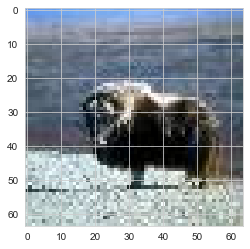

In [10]:
image_nr=1000
print(X_data[image_nr])
print(y_train[image_nr])
plt.imshow(X_data[image_nr])


[[[136 136  98]
  [ 11   9   0]
  [ 48  43   1]
  ...
  [206 127  35]
  [112  30   0]
  [112  30   0]]

 [[254 254 216]
  [254 252 213]
  [ 20  13   0]
  ...
  [152  72   0]
  [233 152  71]
  [127  46   0]]

 [[246 246 210]
  [243 239 201]
  [ 11   4   0]
  ...
  [159  77   3]
  [192 109  39]
  [173  90  22]]

 ...

 [[ 61  10   0]
  [163 112  33]
  [203 149  25]
  ...
  [  0   0  16]
  [  8   0  15]
  [ 31  13  25]]

 [[ 36   0   0]
  [158 112  34]
  [201 152  31]
  ...
  [  0   3  19]
  [  5   0  13]
  [ 31  15  26]]

 [[ 36   0   0]
  [131  90  11]
  [149 103   0]
  ...
  [  0   3  19]
  [  3   0  11]
  [ 24   8  19]]]
n02099601


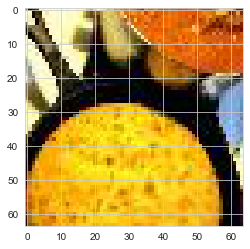

In [22]:
image_nr=1100
print(X_val_data[image_nr])
print(y_val[image_nr])
plt.imshow(X_val_data[image_nr])

In [23]:
print(y_train[0:10])

['n01443537' 'n01443537' 'n01443537' 'n01443537' 'n01443537' 'n01443537'
 'n01443537' 'n01443537' 'n01443537' 'n01443537']


(256, 1)


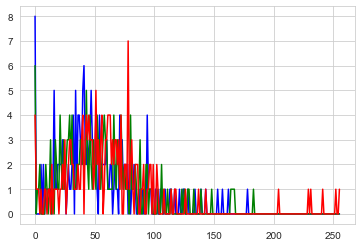

In [24]:
#Example of RGB histogram plot
images=X_data[image_nr]
channels = [0] # [1] or [2] for green or red 0 is blue
mask= None
histSize = [256] # Number of bins, forr full scale take 256
ranges= [0,256] # this is our RANGE. Normally, it is [0,256].
hist_blue=cv2.calcHist(images, channels, mask, histSize, ranges)
hist_green=cv2.calcHist(images, [1], mask, histSize, ranges)
hist_red=cv2.calcHist(images, [2], mask, histSize, ranges)
#plt.plot(hist_blue, hist_green, hist_red)
plt.plot(hist_blue, color= 'blue')
plt.plot(hist_green, color= 'green')
plt.plot(hist_red , color ='red')
print(hist_green.shape)

In [25]:
mask= None
histSize = [256] # Number of bins, forr full scale take 256
ranges= [0,256] # this is our RANGE. Normally, it is [0,256].

data=[]
for i in range(0,len(X_data[0:1000])):
    hist=np.empty((0,0))
    images = X_data[i]
    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_blue=cv2.calcHist(images, [0], mask, histSize, ranges)
    hist_green=cv2.calcHist(images, [1], mask, histSize, ranges)
    hist_red=cv2.calcHist(images, [2], mask, histSize, ranges)
    hist = np.append(hist, hist_blue)
    hist = np.append(hist, hist_green)
    hist = np.append(hist, hist_red)
    featureVector=hist
    #if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
    #    print("Unexpected length of feature vector: " + i)
    data.append((featureVector))
    np_data=np.array(data)
#print(data)

data=[]
for i in range(0,len(X_val_data[0:1000])):
    hist=np.empty((0,0))
    images = X_val_data[i]
    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_blue=cv2.calcHist(images, [0], mask, histSize, ranges)
    hist_green=cv2.calcHist(images, [1], mask, histSize, ranges)
    hist_red=cv2.calcHist(images, [2], mask, histSize, ranges)
    hist = np.append(hist, hist_blue)
    hist = np.append(hist, hist_green)
    hist = np.append(hist, hist_red)
    featureVector=hist
    #if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
    #    print("Unexpected length of feature vector: " + i)
    data.append((featureVector))
np_data_test=np.array(data)

print(np_data_test.shape)
print(np_data.shape)


(1000, 768)
(1000, 768)


In [30]:
dataOpenCV_1D=[]
dataOpenCV_2D=[]
dataOpenCV_3D=[]

# use our own simple function to flatten the 2D arrays
flatten = lambda l: [item for sublist in l for item in sublist]

for i in range(0,len(X_data[0:1000])):
    featuresOpenCV_1D = []
    #hist=np.empty((0,0))
    images = X_data[i]
    
    channels= ([0], [1], [2])
    color = ("b", "g", "r")
    
    histSize_1d=[64] 
    featuresOpenCV_1D = []
    for (channels, color) in zip(channels,color):
        
        # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
        # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
        #imagePIL = imagePIL.convert('RGB')   
        #images = imagePIL.convert('RGB') 
        hist_opencv=cv2.calcHist(images, channels, mask, histSize_1d, ranges)
        featuresOpenCV_1D=np.append(featuresOpenCV_1D, hist_opencv)
    featureVectorOpenCV_1D = featuresOpenCV_1D
    dataOpenCV_1D.append(featureVectorOpenCV_1D) 
    
    #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
    #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
    
np_dataOpenCV_1D=np.array(dataOpenCV_1D)

# And for teh test data
dataOpenCV_1D_test=[]
for i in range(0,len(X_val_data[0:1000])):

    #hist=np.empty((0,0))
    images = X_val_data[i]
    
    channels= ([0], [1], [2])
    color = ("b", "g", "r")
    
    histSize_1d=[64] 
    featuresOpenCV_1D = []
    for (channels, color) in zip(channels,color):
        #imagePIL = imagePIL.convert('RGB')   
        #images = imagePIL.convert('RGB') 
        hist_opencv=cv2.calcHist(images, channels, mask, histSize_1d, ranges)
        featuresOpenCV_1D=np.append(featuresOpenCV_1D, hist_opencv)
    featureVectorOpenCV_1D = featuresOpenCV_1D
    dataOpenCV_1D_test.append(featureVectorOpenCV_1D) 
    
    #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
    #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
    
np_dataOpenCV_1D_test=np.array(dataOpenCV_1D_test)

#print(data)
print(np_dataOpenCV_1D.shape)
print(np_dataOpenCV_1D)

(1000, 192)
[[  0.   0.   0. ...   6.   8.  17.]
 [  1.   9.  13. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   3.]
 ...
 [  0.   0.   0. ...   3.   2.   1.]
 [ 57.  23.  18. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.  20. 172.]]


In [38]:
dataOpenCV_2D=[]

for i in range(0,len(X_data[0:1000])):
    featuresOpenCV_2D = []
    #hist=np.empty((0,0))
    images = X_data[i]
    
    channels= [[0], [1], [2]]
    color = ("b", "g", "r")
    
    histSize_2d= 16 
    featuresOpenCV_2D = []
        
    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_opencv_2d_1 = cv2.calcHist(images,  [0,1], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    hist_opencv_2d_2 = cv2.calcHist(images,  [0,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    hist_opencv_2d_3 = cv2.calcHist(images,  [1,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_1)
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_2)
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_3)
    featureVectorOpenCV_2D = featuresOpenCV_2D # and append this to our feature vector
    dataOpenCV_2D.append(featureVectorOpenCV_2D) # now we append the feature vector to the dataset so far
np_dataOpenCV_2D= np.array(dataOpenCV_2D)


# We have to extract features for the test set as well
dataOpenCV_2D_test=[]

for i in range(0,len(X_val_data[0:1000])):
    featuresOpenCV_2D = []
    #hist=np.empty((0,0))
    images = X_val_data[i]
    
    channels= [[0], [1], [2]]
    color = ("b", "g", "r")
    
    histSize_2d= 16 
    featuresOpenCV_2D = []
        
    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_opencv_2d_1 = cv2.calcHist(images,  [0,1], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    hist_opencv_2d_2 = cv2.calcHist(images,  [0,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    hist_opencv_2d_3 = cv2.calcHist(images,  [1,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_1)
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_2)
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_3)
    featureVectorOpenCV_2D = featuresOpenCV_2D # and append this to our feature vector
    dataOpenCV_2D_test.append(featureVectorOpenCV_2D) # now we append the feature vector to the dataset so far
    
    #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
    #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
    
np_dataOpenCV_2D_test= np.array(dataOpenCV_2D_test)

#print(data)
print(np_dataOpenCV_2D.shape)
print(np_dataOpenCV_2D)

(1000, 768)
[[  0.   0.   0. ...   0.   1.  34.]
 [ 20.  16.   1. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   3.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [ 71.  21.   6. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0. 192.]]


In [28]:
dataOpenCV_3D=[]

for i in range(0,len(X_data[0:1000])):
    featuresOpenCV_2D = []
    #hist=np.empty((0,0))
    images = X_data[i]
    
    channels= [[0], [1], [2]]
    color = ("b", "g", "r")
    
    histSize_3d= 8 
    featuresOpenCV_3D = []
        
        # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
        # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
        #imagePIL = imagePIL.convert('RGB')   
        #images = imagePIL.convert('RGB') 
    hist_opencv_3d = cv2.calcHist(images,  [0,1,2], mask, [histSize_3d, histSize_3d,histSize_3d ], [0, 256, 0, 256,  0, 256])
    featuresOpenCV_3D= np.append(featuresOpenCV_2D, hist_opencv_3d)
    featureVectorOpenCV_3D = featuresOpenCV_3D # and append this to our feature vector
    dataOpenCV_3D.append(featureVectorOpenCV_3D) # now we append the feature vector to the dataset so far
    #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
    #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i    
np_dataOpenCV_3D= np.array(dataOpenCV_3D)

# and for the test set
dataOpenCV_3D_test=[]
for i in range(0,len(X_val_data[0:1000])):
    featuresOpenCV_2D = []
    #hist=np.empty((0,0))
    images = X_val_data[i]
    
    channels= [[0], [1], [2]]
    color = ("b", "g", "r")
    
    histSize_3d= 8 
    featuresOpenCV_3D = []

    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_opencv_3d = cv2.calcHist(images,  [0,1,2], mask, [histSize_3d, histSize_3d,histSize_3d ], [0, 256, 0, 256,  0, 256])
    featuresOpenCV_3D= np.append(featuresOpenCV_2D, hist_opencv_3d)
    featureVectorOpenCV_3D = featuresOpenCV_3D # and append this to our feature vector
    dataOpenCV_3D_test.append(featureVectorOpenCV_3D) # now we append the feature vector to the dataset so far

np_dataOpenCV_3D_test= np.array(dataOpenCV_3D_test)
print(np_dataOpenCV_3D.shape)
print(np_dataOpenCV_3D.shape)
print(np_dataOpenCV_3D)

(1000, 512)
(1000, 512)
[[  0.   0.   0. ...   0.   5.  82.]
 [ 91.   5.   3. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   1.]
 [ 46.  13.  25. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0. 192.]]


In [33]:
def calc_score_MLP(mlp, X, Y, cv, epochs, batch_size):
    kfold = KFold(n_splits=cv, shuffle=True)
    acc_per_fold = []
    for train, test in kfold.split(X, Y):
        train_data = np.take(X, train, 0)
        train_target = np.take(Y, train, 0)
        test_data = np.take(X, test, 0)
        test_target = np.take(Y, test, 0)
        history = mlp.fit(train_data, np_utils.to_categorical(train_target), batch_size=batch_size, epochs=epochs, verbose=0)
        y_pred = mlp.predict(test_data)
        print(y_pred)
        score = accuracy_score(y_pred, test_target)
        acc_per_fold.append(score)
    return np.array(acc_per_fold)

([<matplotlib.axis.XTick at 0x246c489f130>,
 [Text(0, 0, '1D RBG 256'),
  Text(1, 0, '1D RBG 64'),
  Text(2, 0, '2D RBG'),
  Text(3, 0, '3D RBG')])

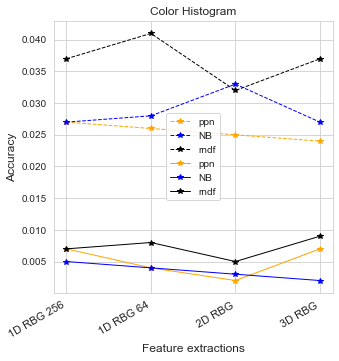

In [41]:
# Classification
import warnings
warnings.filterwarnings('ignore')

# these are our feature sets; we will use each of them individually to train classifiers
trainingSets = [np_data, np_dataOpenCV_1D, np_dataOpenCV_2D, np_dataOpenCV_3D]
TestSets = [np_data_test, np_dataOpenCV_1D_test, np_dataOpenCV_2D_test, np_dataOpenCV_3D_test]

vals      = trainingSets
vals_test      = TestSets
trainingLabel=y_train[0:1000]
scores    = []
scores_ppn, scores_NB, scores_rndf, scores_mlp = [], [], [], []
scores_ppn_test, scores_NB_test, scores_rndf_test, scores_mlp_test = [], [], [], []
for X, X_t in zip(vals, vals_test):
    ppn = create_perceptron(pd.DataFrame(X), pd.DataFrame(trainingLabel))
    scores_ppn.append(cross_val_score(ppn, pd.DataFrame(X), pd.DataFrame(trainingLabel), scoring="accuracy", cv=10).mean())
    scores_ppn_test.append(accuracy_score(y_test[0:1000], ppn.predict(X_t),normalize=True))
    
    NB = create_nb(pd.DataFrame(X), pd.DataFrame(trainingLabel))
    scores_NB.append(cross_val_score(NB, pd.DataFrame(X), pd.DataFrame(trainingLabel), scoring="accuracy", cv=10).mean())
    scores_NB_test.append(accuracy_score(y_test[0:1000], NB.predict(X_t),normalize=True))
    
    rndf = create_rnd_forrest(pd.DataFrame(X), pd.DataFrame(trainingLabel),random_state=42, n_estimators=50)
    scores_rndf.append(cross_val_score(rndf, pd.DataFrame(X), pd.DataFrame(trainingLabel), scoring="accuracy", cv=10).mean())
    scores_rndf_test.append(accuracy_score(y_test[0:1000], rndf.predict(X_t),normalize=True))

    """
    create_scaling(X)
    X = scaler.transform(X)
    
    mlp = create_MLP(X, trainingLabel)
    scores_mlp.append(calc_score_MLP(mlp, X, trainingLabel, cv=10, epochs=15, batch_size=64).mean())
    scores_mlp_test.append(accuracy_score(y_test, mlp.predict(X_t),normalize=True))
    """

Nr_data = np.arange(4)
plt.figure(figsize=(5,5))

plt.plot(Nr_data, scores_ppn,"--",color="orange",marker="*", linewidth=1,label="ppn")
plt.plot(Nr_data, scores_NB,"--",color="blue",marker="*", linewidth=1,label="NB")
plt.plot(Nr_data, scores_rndf,"--",color="black",marker="*", linewidth=1,label="rndf")
#plt.plot(Nr_data, scores_mlp,"--",color="green",marker="*", linewidth=1,label="mlp")
plt.plot(Nr_data, scores_ppn_test,"-",color="orange",marker="*", linewidth=1,label="ppn")
plt.plot(Nr_data, scores_NB_test,"-",color="blue",marker="*", linewidth=1,label="NB")
plt.plot(Nr_data, scores_rndf_test,"-",color="black",marker="*", linewidth=1,label="rndf")
#plt.plot(Nr_data, scores_mlp_test,"-",color="green",marker="*", linewidth=1,label="mlp")

plt.legend(loc="best")
plt.title("Color Histogram",fontsize=12)
plt.ylabel("Accuracy",fontsize=12)
plt.xlabel("Feature extractions",fontsize=12)
labels =["1D RBG 256", "1D RBG 64", "2D RBG", "3D RBG"]
plt.xticks(Nr_data, labels,rotation=30,fontsize=11, ha="right")
#plt.savefig("./Perceprton_Color_hist.pdf")
  
        

# SIFT

In [79]:
Image_grey=cv2.cvtColor(X_data[0], cv2.COLOR_BGR2GRAY)
print(X_data[0])


[[[255 137 192]
  [255 139 192]
  [246 148 197]
  ...
  [208 237 235]
  [207 241 240]
  [125 164 161]]

 [[255 124 189]
  [255 128 189]
  [246 137 194]
  ...
  [203 232 230]
  [200 235 231]
  [121 160 157]]

 [[255 124 201]
  [255 127 201]
  [255 134 203]
  ...
  [207 233 230]
  [200 235 229]
  [119 156 149]]

 ...

 [[ 94 122  71]
  [ 93 119  71]
  [ 93 116  70]
  ...
  [ 85  74  56]
  [ 78  67  49]
  [ 94  83  65]]

 [[ 89 118  64]
  [ 88 116  65]
  [ 87 113  66]
  ...
  [ 86  75  57]
  [ 77  66  48]
  [ 87  76  58]]

 [[ 91 120  66]
  [ 91 119  68]
  [ 91 117  70]
  ...
  [ 96  85  67]
  [ 77  66  48]
  [ 72  61  43]]]


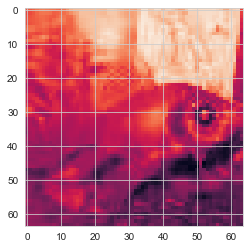

In [80]:
plt.imshow(Image_grey)


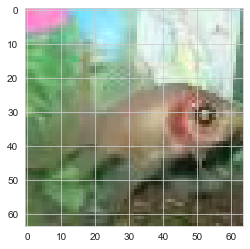

In [81]:
plt.imshow(X_data[0])

In [83]:
sift=cv2.xfeatures2d.SIFT_create()

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'